In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [4]:
tsla_filepath = os.path.join(os.getcwd(), 'tsla.csv')
goog_filepath = os.path.join(os.getcwd(), 'goog.csv')
eth_filepath = os.path.join(os.getcwd(), 'eth.csv')
btc_filepath = os.path.join(os.getcwd(), 'btc.csv')

tsla_df = pd.read_csv(tsla_filepath)
goog_df = pd.read_csv(goog_filepath)
eth_df = pd.read_csv(eth_filepath)
btc_df = pd.read_csv(btc_filepath)

In [5]:
# Function to clean data
def clean_data(df):
    df = df[['Date', 'Close']]  # Select only the 'Date' and the 'Close' column
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
    df = df.dropna().reset_index(drop=True)  # Drop rows with NaN and reset the index

    return df

In [6]:
tsla_df = clean_data(tsla_df)
goog_df = clean_data(goog_df)
eth_df = clean_data(eth_df)
btc_df = clean_data(btc_df)

<ipython-input-5-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-5-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-5-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [8]:
# Function to preprocess data (splitting, scaling, and preparing training data)
def preprocess_data(data, train_split=0.7, window_size=100):
    # Splitting the data into training and testing
    data_training = data[0:int(len(data) * train_split)]
    data_testing = data[int(len(data) * train_split):]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_training_array = scaler.fit_transform(data_training)

    # Preparing training data
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i - window_size:i])
        y_train.append(data_training_array[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    return x_train, y_train, data_testing, scaler

In [9]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [10]:
# Function to prepare test data
def prepare_test_data(data_testing, data_training, scaler, window_size=100):
    past_data = data_training.tail(window_size)
    final_data = pd.concat([past_data, data_testing], ignore_index=True)
    input_data = scaler.transform(final_data)

    x_test, y_test = [], []
    for i in range(window_size, len(input_data)):
        x_test.append(input_data[i - window_size:i])
        y_test.append(input_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    return x_test, y_test

In [11]:
# Function to plot predictions with proper x-axis handling
def plot_predictions(y_test, y_predicted, scaler, test_dates, tick_interval=365):
    # Reverse scaling
    scale_factor = 1 / scaler.scale_[0]
    y_test = y_test * scale_factor
    y_predicted = y_predicted * scale_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Original Price', linewidth=1)
    plt.plot(test_dates, y_predicted, label='Predicted Price', linewidth=1)

    # Formatting x-axis
    plt.xlabel('Date')  # Label for x-axis
    plt.ylabel('Price (USD)')  # Label for y-axis
    plt.title('Predicted Price vs. Actual Price')  # Add a title

    # Ensure evenly spaced x-axis ticks
    plt.xticks(test_dates[::tick_interval])  # Show every tick_interval-th date

    # Adjust x-axis limits
    plt.xlim(test_dates.iloc[0], test_dates.iloc[-1])  # Ensure the plot spans all dates

    # Add legend and show the plot
    plt.legend()
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

In [12]:
# Main function to train and test the model for a given stock
def train_and_test_lstm(stock_data, epochs=10, window_size=100):
    # Preprocessing the data
    x_train, y_train, data_testing, scaler = preprocess_data(stock_data[['Close']], window_size=window_size)

    # Building the model
    model = build_lstm_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, epochs=epochs, batch_size=32)

    # Preparing test data
    x_test, y_test = prepare_test_data(data_testing, stock_data[['Close']], scaler, window_size=window_size)

    # Making predictions
    y_predicted = model.predict(x_test)

    # Extracting test dates
    test_dates = pd.to_datetime(stock_data.iloc[-len(data_testing):]['Date']).reset_index(drop=True)

    # Return the results
    return y_test, y_predicted, scaler, test_dates, model

In [ ]:
def short_term_future_pred(dataframe, scaler, model, days_to_predict_list, lookback=60, column='Close'):

    # Step 1: Scale the data
    scaled_data = scaler.fit_transform(dataframe[[column]])

    # Step 2: Extract the last `lookback` days and reshape
    last_lookback_days = scaled_data[-lookback:]
    x_future = last_lookback_days.reshape((1, lookback, 1))

    # Ensure the DataFrame index is a DatetimeIndex
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    if not isinstance(dataframe.index, pd.DatetimeIndex):
        raise ValueError("The index of the DataFrame is not a valid DatetimeIndex.")

    # Step 3: Initialize results container
    forecasts = {}

    # Step 4: Generate forecasts for each time horizon
    for days_to_predict in days_to_predict_list:
        # Reset for each forecast
        x_future_current = x_future.copy()
        future_predictions = []

        for _ in range(days_to_predict):
            pred = model.predict(x_future_current)
            future_predictions.append(pred[0, 0])
            x_future_current = np.append(x_future_current[:, 1:, :], [[pred[0]]], axis=1)

        # Transform predictions back to the original scale
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

        # Prepare forecast dates
        forecast_dates = pd.date_range(start=dataframe.index[-1] + pd.Timedelta(days=1), periods=days_to_predict, freq='B')
        forecast_df = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Prediction'])

        # Store the forecast
        forecasts[f"{days_to_predict} days"] = forecast_df

        # Step 5: Plot the forecast
        plt.figure(figsize=(10, 5))
        plt.plot(forecast_df, label=f'{days_to_predict}-Day Forecast', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.title(f'{days_to_predict}-Day Stock Price Forecast')
        plt.legend()
        plt.show()

    return forecasts

In [13]:
# Train the model and get data
tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tsla_model = train_and_test_lstm(tsla_df, epochs=10, window_size=100)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 286ms/step - loss: 0.0096
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.0023
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - loss: 9.8546e-04
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 358ms/step - loss: 0.0010
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - loss: 0.0014
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - loss: 0.0011
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - loss: 0.0027
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 0.0011
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 290ms/step - loss: 0.0013
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 9.8656e-04
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step


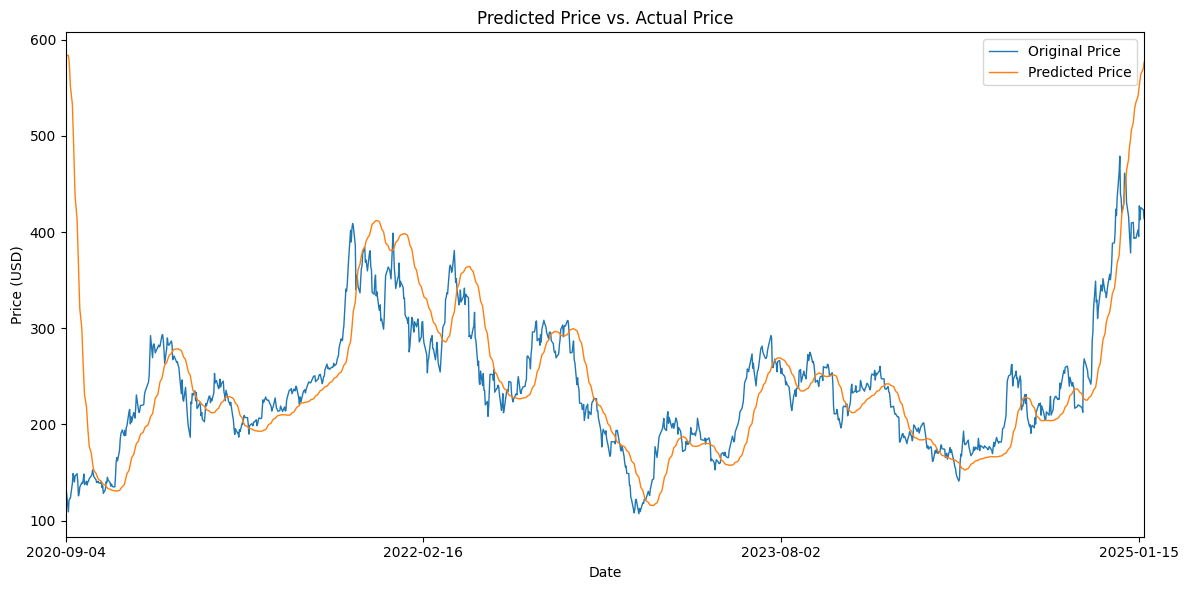

In [14]:
# Plot predictions (adjust tick_interval as needed, e.g., every 365 days)
plot_predictions(tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tick_interval=365)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━

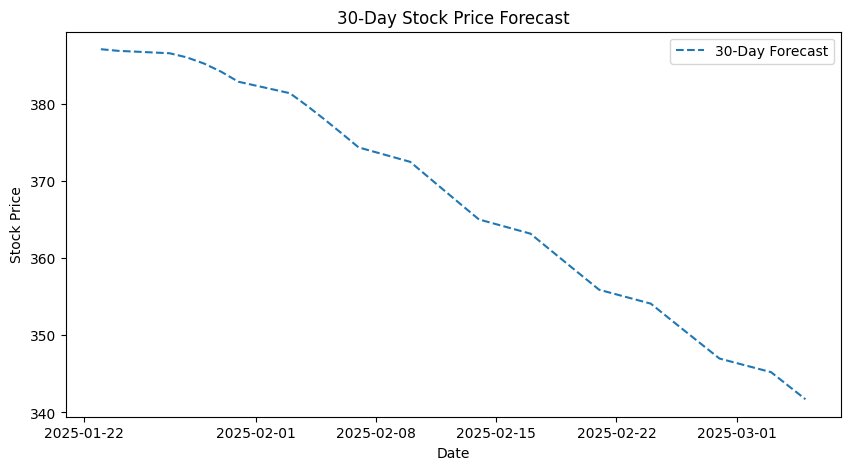

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

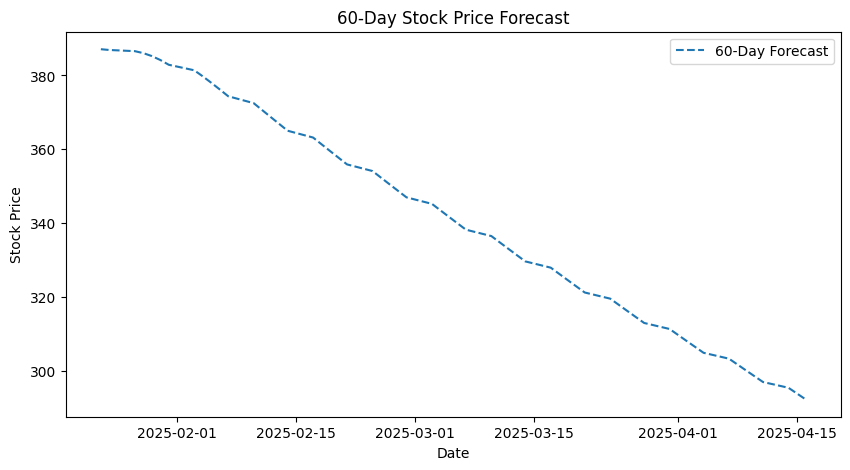

In [39]:
tsla_forecast_df = short_term_future_pred(tsla_df, tsla_scaler, tsla_model, days_to_predict_list=[30, 60], lookback=90, column='Close')

In [41]:
goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, goog_model = train_and_test_lstm(goog_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - loss: 0.0581
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.0050
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.0045
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - loss: 0.0040
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - loss: 0.0032
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - loss: 0.0036
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - loss: 0.0031
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.0030
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 304ms/step - loss: 0.0030
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - loss: 0.0032
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step


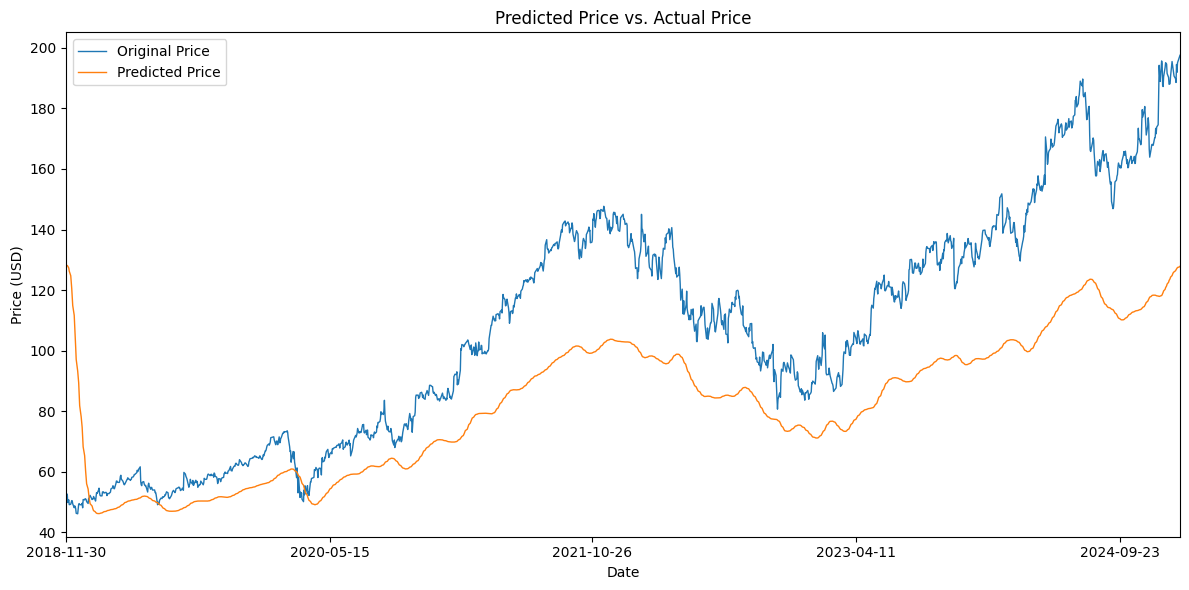

In [43]:
plot_predictions(goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, tick_interval=365)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

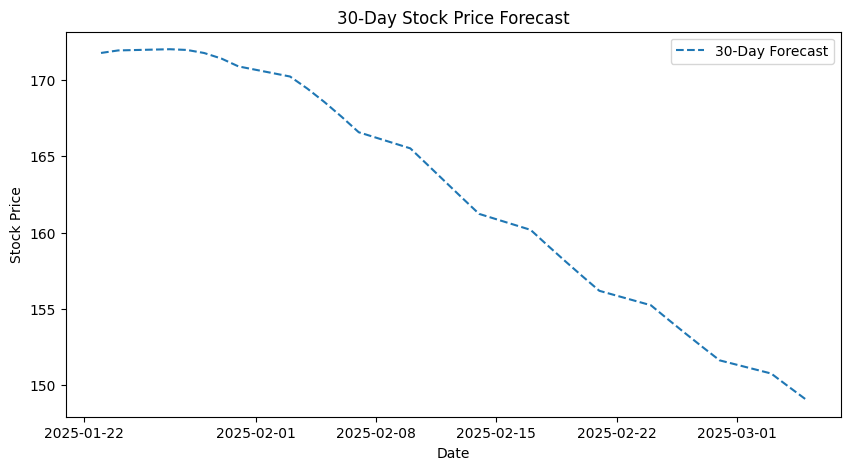

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━

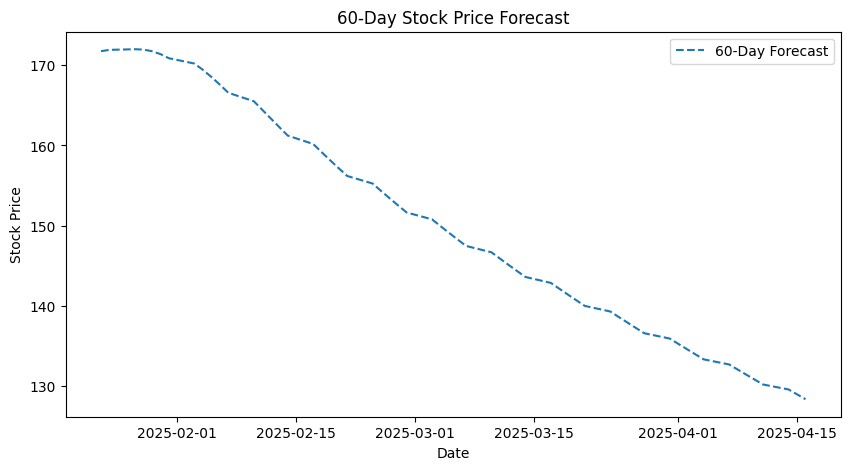

In [44]:
goog_forecast_df = short_term_future_pred(goog_df, goog_scaler, goog_model, days_to_predict_list=[30, 60], lookback=90, column='Close')

In [45]:
eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, eth_model = train_and_test_lstm(eth_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - loss: 0.0546
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - loss: 0.0082
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - loss: 0.0067
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 0.0067
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - loss: 0.0057
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - loss: 0.0053
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - loss: 0.0051
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - loss: 0.0047
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - loss: 0.0043
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.0047
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


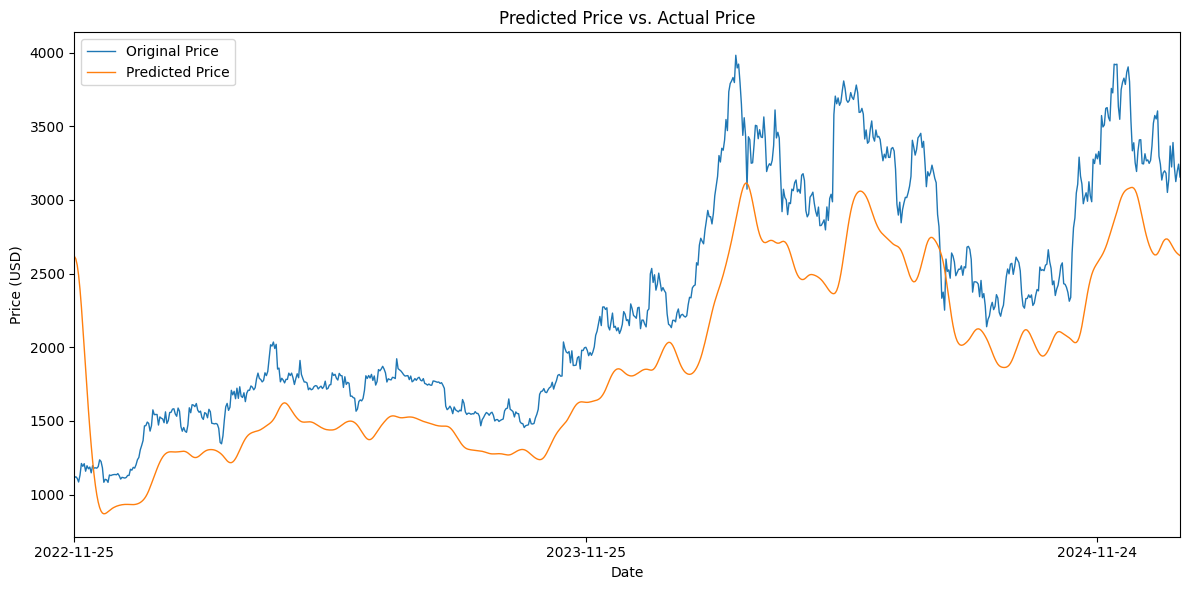

In [46]:
plot_predictions(eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, tick_interval=365)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

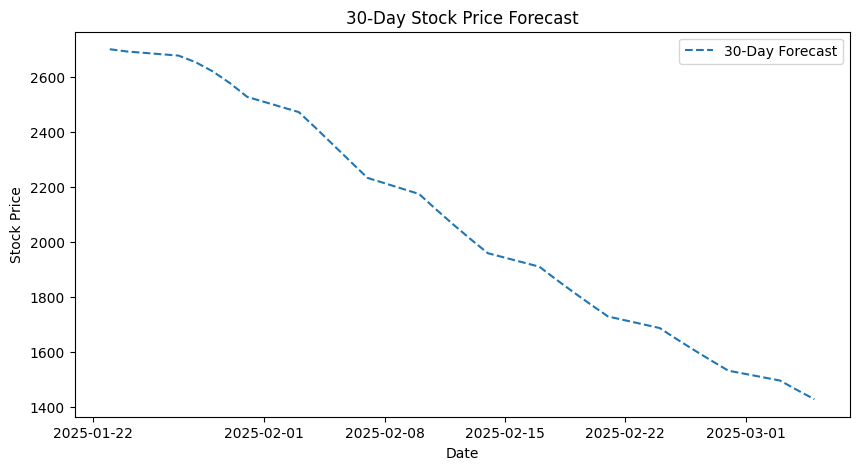

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

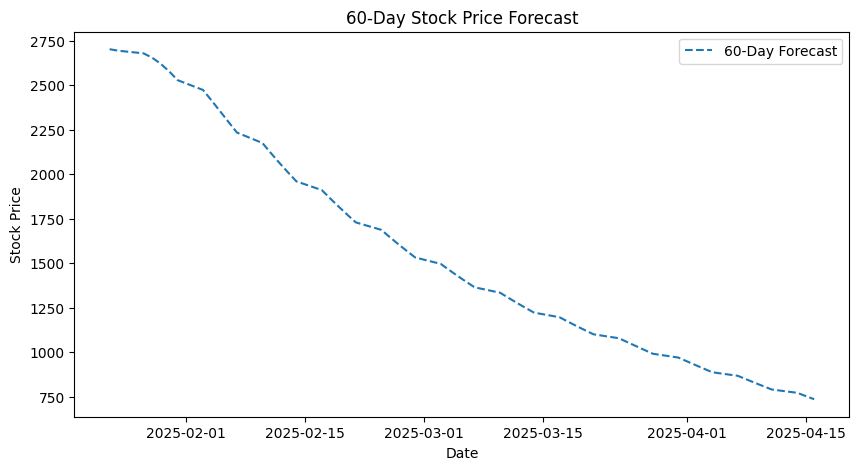

In [47]:
eth_forecast_df = short_term_future_pred(eth_df, eth_scaler, eth_model, days_to_predict_list=[30, 60], lookback=90, column='Close')

In [48]:
btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, btc_model = train_and_test_lstm(btc_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - loss: 0.0328
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - loss: 0.0059
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.0039
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - loss: 0.0035
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.0033
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - loss: 0.0038
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - loss: 0.0029
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - loss: 0.0033
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - loss: 0.0030
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - loss: 0.0025
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step


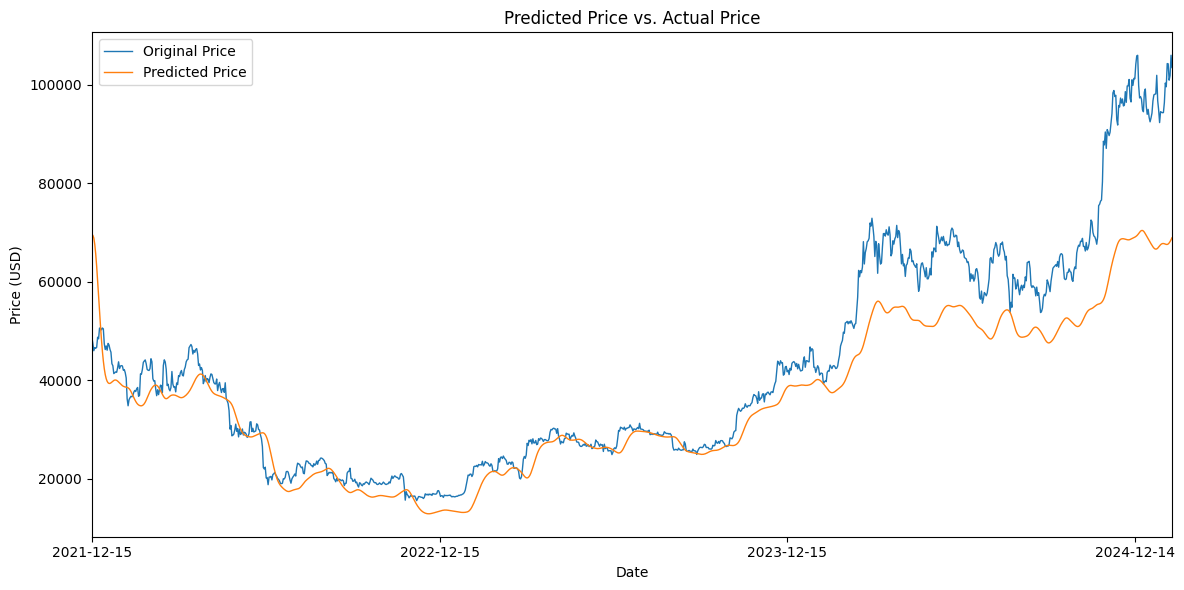

In [49]:
plot_predictions(btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, tick_interval=365)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

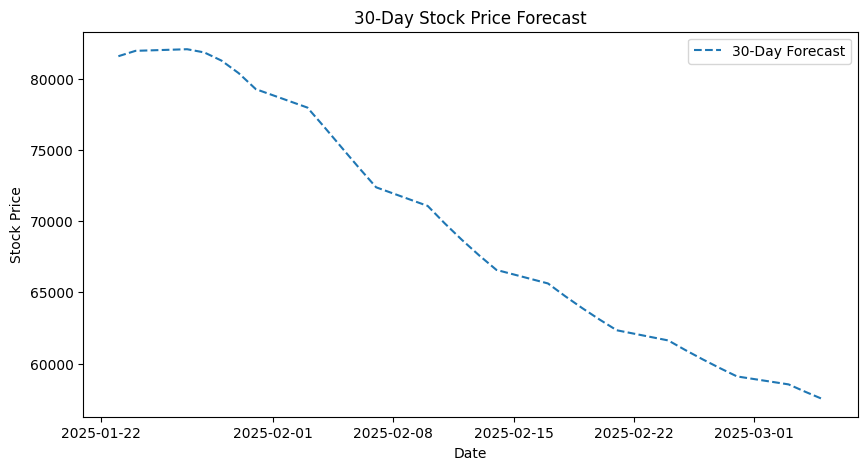

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

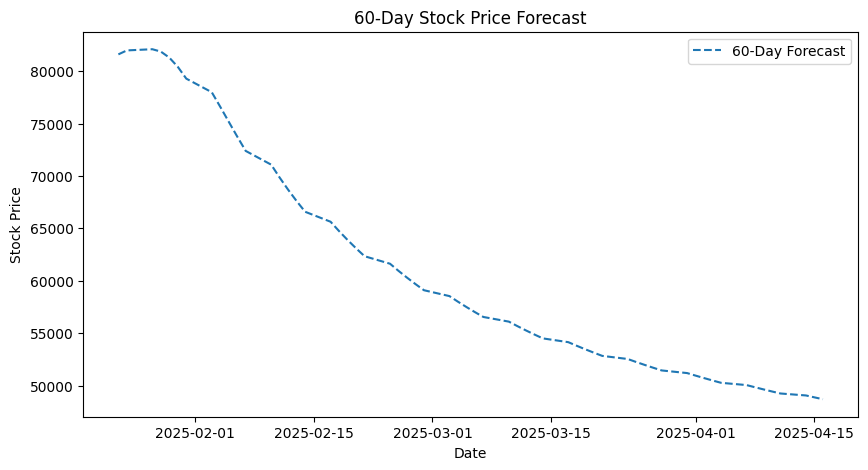

In [50]:
btc_forecast_df = short_term_future_pred(btc_df, btc_scaler, btc_model, days_to_predict_list=[30, 60], lookback=90, column='Close')